## Smile Detection

In this notebook, we will be looking at using the trained model to do inference on images. A face detector is first required to detect faces in the image and that cropped face will be sent to the trained model for inference. 

### Importing the necessary packages

In [165]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import io

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from scipy.ndimage import zoom
from PIL import Image
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
print("Warnings ignored!!")

%load_ext autoreload
%autoreload 2

Warnings ignored!!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inference procedure
There are three steps to this smile detector function. Detect the face, extract the face, determine smiling or not using model. Face detection was done using an existing face detector that is widely used. The images were converted to gray scale as the face detector seem to only work on gray scaled images. 

The extract_face function ensures that the picture extracted matches the olivetti data set where the size of the image has to be 64x64. 

The smiling function uses the face_detect and extract_face function and outputs 'smiling' or 'not smiling' if a face is detected.

In [204]:
def load_input_img(img_data):
    """Loads an image from the input file path"""
    if isinstance(img_data, str):
        with open(img_data, 'rb') as file:
            img_bytes = file.read()
    elif isinstance(img_data, (bytes, bytearray)):
        img_bytes = img_data
    else:
        img_bytes = img_data.read()
    output_img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
    return output_img


def face_detect(face_detector, img):
    """Takes a image path as input and a face detector and outputs the grayed image and the coordinates of the face detected"""
    test_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) #cv2.imread(path)
    grayed_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    face_coordinates = face_detector.detectMultiScale(grayed_img, 1.1, 5)
    return grayed_img, face_coordinates


def extract_face(img, face_coordinates):
    """Takes an image and face coordinates as input and crops out the face and does the mobilenet preprocessing required"""
    if len(face_coordinates)==0:
        return 'No face detected'
    for (x,y,w,h) in face_coordinates:
        extracted_face = img[y:y+h, x:x+w]
        extracted_face = cv2.resize(extracted_face, (224, 224))
        extracted_face = cv2.cvtColor(extracted_face, cv2.COLOR_GRAY2RGB)
        extracted_face = preprocess_input(extracted_face)
        
    return extracted_face


def smiling(path, smile_classifier, face_detector):
    """Uses the above helper functions to output the smile classification of the image"""
    loaded_img = load_input_img(path)
    grayed_img, face_coord = face_detect(face_detector, loaded_img)
    
    if len(face_coord)== 0:
        return 'Face not detected'

    else:
        face_extract = extract_face(grayed_img, face_coord)
        labels = ('not smiling','smiling')
        prediction = smile_classifier.predict(np.expand_dims(face_extract, axis=0))[0]
        pred_label = np.argmax(prediction)
        confidence = prediction[pred_label]
        return labels[pred_label], confidence, face_coord
    
def visualize_classifier(img_path, smile_classifier, face_detector):
    font_scale = 1.2
    font = cv2.FONT_HERSHEY_PLAIN

    smile_class, conf, face_coor = smiling(img_path, smile_classifier, face_detector)
    img = cv2.imread(img_path)
    
    msg = f'{smile_class}, {conf:.3f}'
    t_size = cv2.getTextSize(smile_class, 0, fontScale=font_scale, thickness=1)[0]
    for (x,y,w,h) in face_coor:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)            
        cv2.rectangle(img, (x, y), (x + t_size[0], y-t_size[1]-3), (0,0,0), -1)  # filled
        cv2.putText(img, msg, (x, y-2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), 2, lineType=cv2.LINE_AA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    

Some images were downloaded from flickr to be tested and one of the test can be found below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


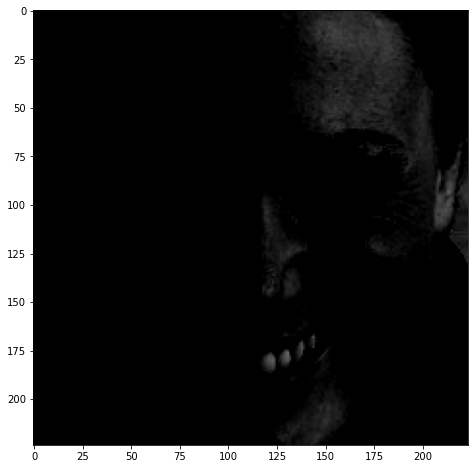

In [195]:
base_path = os.path.join(os.getcwd(), '..')
data_path = os.path.join(base_path, 'data')
test_img_dir = os.path.join(base_path, 'data', 'test_images')
face_detector_path = os.path.join(base_path, 'haarcascade_frontalface_default.xml')
test_img_path = os.path.join(test_img_dir, 'smile_test_7.jpg')

face_detector = cv2.CascadeClassifier(face_detector_path)
test_img = load_input_img(test_img_path)
gray_img , face_coor = face_detect(face_detector, test_img)
face_extract = extract_face(gray_img, face_coor)

plt.figure(figsize=(8,8))
plt.imshow(face_extract)

Accuracy of the model itself may not be very good due to lack of data and an model that may have been overfitted due to large number of epochs. May explore using the entire dataset fully instead of just 80% of the data but that would make it harder for validation as would need to have another set of images where faces can be detected. 

In [196]:
model_path = os.path.join(data_path, 'models', 'tf_mobilenetv2.h5')

test_model = tf.keras.models.load_model(model_path)
face_detector = cv2.CascadeClassifier(face_detector_path)
test_img = smiling(test_img_path, test_model, face_detector)
print(test_img)

('smiling', array([[293, 144, 275, 275]], dtype=int32))


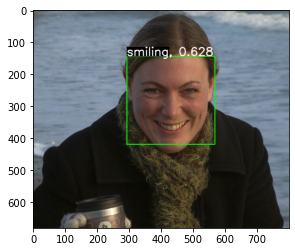

In [205]:
visualize_classifier(test_img_path, test_model, face_detector)